# Heart Disease Classification

## Imports

In [1]:
#!pip install xgboost #Uncomment to install XGBoost package

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from itertools import product
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from utils import *

## Data Preprocessing

In [2]:
filename = 'data/heart_cleveland_upload.csv'
df = pd.read_csv(filename)

print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [3]:
# Show basic info
print(df.info())  # Check for missing values and data types
print(df.describe())  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.1

In [4]:
#Checking if dataframe has missing values
if pd.isna(df).values.any()>0:
    print("The Data has missing values")
else:
    print("The Data has no missing values")

The Data has no missing values


### Histograms

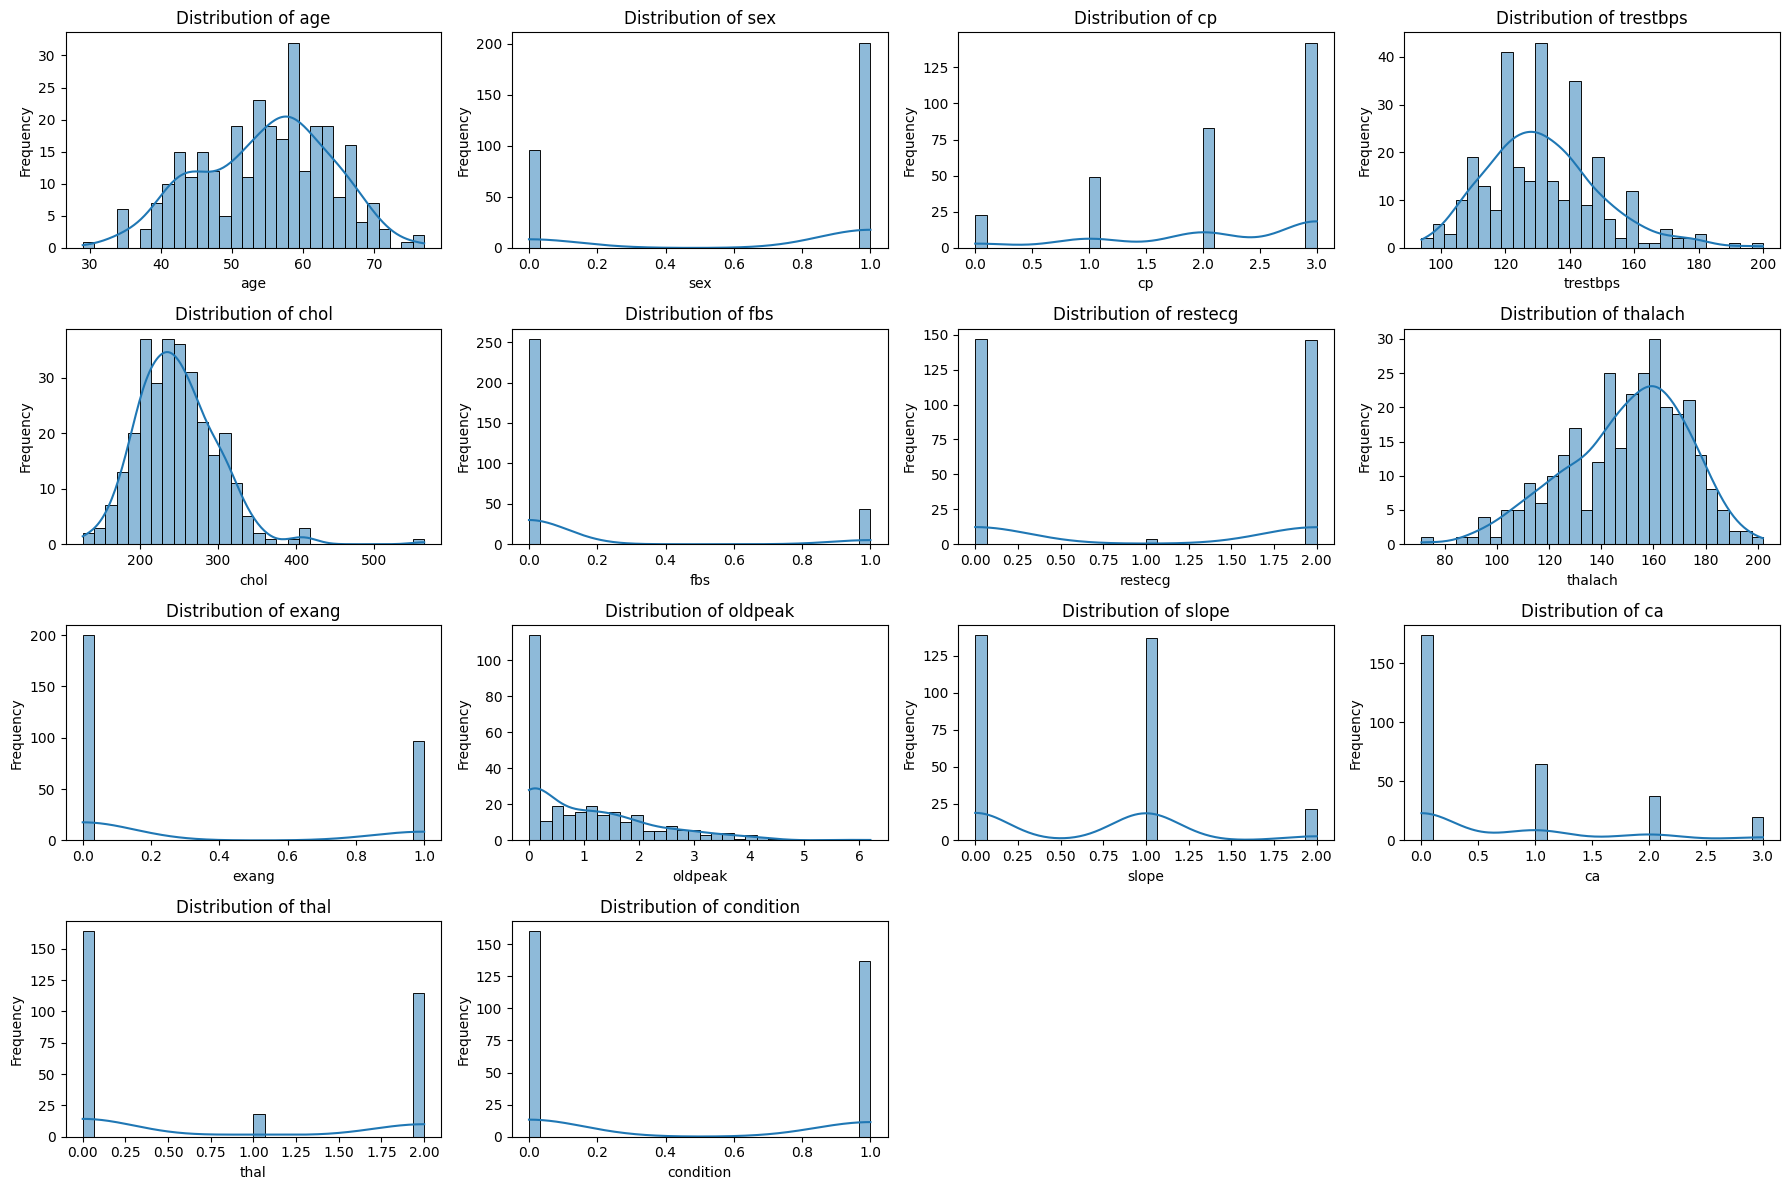

In [5]:
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
# categorical_cols = ['cp', 'restecg', 'slope', 'ca', 'thal']
categorical_cols = ['cp', 'restecg', 'slope', 'thal']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded = df_encoded.astype(int)

print(df_encoded.head())

   age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  ca  condition  \
0   69    1       160   234    1      131      0        0   1          0   
1   69    0       140   239    0      151      0        1   2          0   
2   66    0       150   226    0      114      0        2   0          0   
3   65    1       138   282    1      174      0        1   1          1   
4   64    1       110   211    0      144      1        1   0          0   

   cp_1  cp_2  cp_3  restecg_1  restecg_2  slope_1  slope_2  thal_1  thal_2  
0     0     0     0          0          1        1        0       0       0  
1     0     0     0          0          0        0        0       0       0  
2     0     0     0          0          0        0        1       0       0  
3     0     0     0          0          1        1        0       0       0  
4     0     0     0          0          1        1        0       0       0  


In [7]:
#Checking if the target is balanced
c0=0
c1=0
for value in df_encoded["condition"]:
    if value==1:
        c1+=1
    else:
        c0+=1
print(f"{c1} patients have a condition, {c0} don't")
print(f"Ratio of patients: {c1/(c1+c0)}")

137 patients have a condition, 160 don't
Ratio of patients: 0.4612794612794613


In [8]:
#As it looks since there is no high disparity between healthy people and pacients
#Next in line is Normalization
scaler = StandardScaler()

#will drop the condition label
target = df_encoded["condition"]
print(target.head())
df_encoded = df_encoded.drop("condition", axis=1)
# col_n = ["age", "trestbps", "chol", "thalach", "oldpeak"]
col_n = ["age", "trestbps", "chol", "thalach", "oldpeak", 'ca']
df_stand = df_encoded[col_n]

df_stand = scaler.fit_transform(df_stand)
df_encoded[col_n] = df_stand
print(df_encoded)

0    0
1    0
2    0
3    1
4    0
Name: condition, dtype: int64
          age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0    1.600302    1  1.596266 -0.257179    1 -0.812095      0 -0.723395   
1    1.600302    0  0.468418 -0.160859    0  0.061157      0  0.206684   
2    1.268242    0  1.032342 -0.411292    0 -1.554358      0  1.136764   
3    1.157555    1  0.355633  0.667499    1  1.065396      0  0.206684   
4    1.046868    1 -1.223355 -0.700254    0 -0.244481      1  0.206684   
..        ...  ...       ...       ...  ...       ...    ...       ...   
292 -1.609620    1  1.145127 -0.469085    0  1.371034      0 -0.723395   
293 -1.720306    1 -0.772215 -0.546141    0 -0.419131      0  0.206684   
294 -2.163054    1 -0.659431 -0.950688    0 -0.855757      1  0.206684   
295 -2.163054    0  0.355633 -1.239649    0  1.414697      0  0.206684   
296 -2.163054    1 -0.321076  0.667499    0  0.279470      1 -0.723395   

           ca  cp_1  cp_2  cp_3  restecg_1  re

### Split data into Train and Test Set

In [9]:
X = df_encoded
y = target

#Shuffling in order to avoid bias data
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

print(X.head())
print()
print(y.head())

        age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0  1.600302    1  1.596266 -0.257179    1 -0.812095      0 -0.723395   
1  1.600302    0  0.468418 -0.160859    0  0.061157      0  0.206684   
2  1.268242    0  1.032342 -0.411292    0 -1.554358      0  1.136764   
3  1.157555    1  0.355633  0.667499    1  1.065396      0  0.206684   
4  1.046868    1 -1.223355 -0.700254    0 -0.244481      1  0.206684   

         ca  cp_1  cp_2  cp_3  restecg_1  restecg_2  slope_1  slope_2  thal_1  \
0  0.344824     0     0     0          0          1        1        0       0   
1  1.411625     0     0     0          0          0        0        0       0   
2 -0.721976     0     0     0          0          0        0        1       0   
3  0.344824     0     0     0          0          1        1        0       0   
4 -0.721976     0     0     0          0          1        1        0       0   

   thal_2  
0       0  
1       0  
2       0  
3       0  
4       0  

0    0


In [10]:
# Split data into train and test set: 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Shuffled
X_train_shuffle, X_test_shuffle, y_train_shuffle, y_test_shuffle = train_test_split(X_shuffle, y_shuffle, test_size=0.2, random_state=42)

In [11]:
print(f"Training Set:       X_train={X_train.shape},    y_train={y_train.shape}")
print(f"Test Set:           X_test={X_test.shape},      y_test={y_test.shape}")

Training Set:       X_train=(237, 18),    y_train=(237,)
Test Set:           X_test=(60, 18),      y_test=(60,)


## All models

In [12]:
model_names = ('Logistic Regression', 'SVM', 'Random forest', 'KNN', 'XGBoost', 'Neural Network')
best_models = []

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression

### Grid search to find the best parameter C

In [14]:
# log_reg = LogisticRegression(solver='liblinear', max_iter=300)

# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100]
# }

# grid_search = GridSearchCV(
#     estimator=log_reg,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     verbose=1
# )

# grid_search.fit(X_train_shuffle, y_train_shuffle)

# best_log_reg = grid_search.best_estimator_
# best_models.append(best_log_reg)
# print("Best C from GridSearchCV:", grid_search.best_params_['C'])

### Best parameter is C=1

In [15]:
best_log_reg = LogisticRegression(C=1, max_iter=300)
best_log_reg.fit(X_train_shuffle, y_train_shuffle)
best_models.append(best_log_reg)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

In [16]:
# print_classification_report_from_model(best_log_reg, X_train, y_train)
print_classification_report_from_model(best_log_reg, X_train_shuffle, y_train_shuffle)

Classification Report (Train data):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       125
           1       0.90      0.84      0.87       112

    accuracy                           0.88       237
   macro avg       0.88      0.88      0.88       237
weighted avg       0.88      0.88      0.88       237



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        35
           1       0.87      0.80      0.83        25

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60




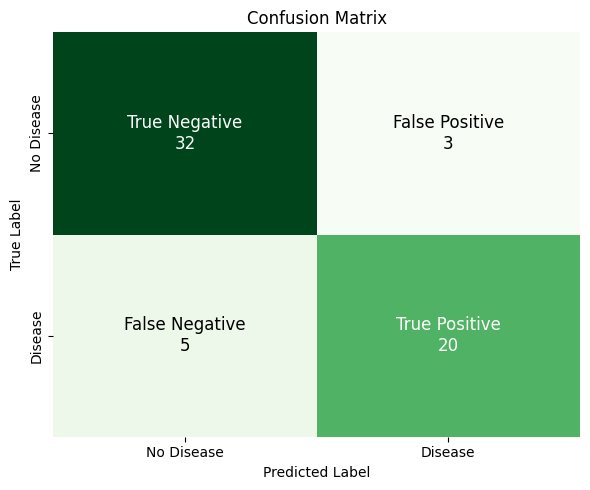

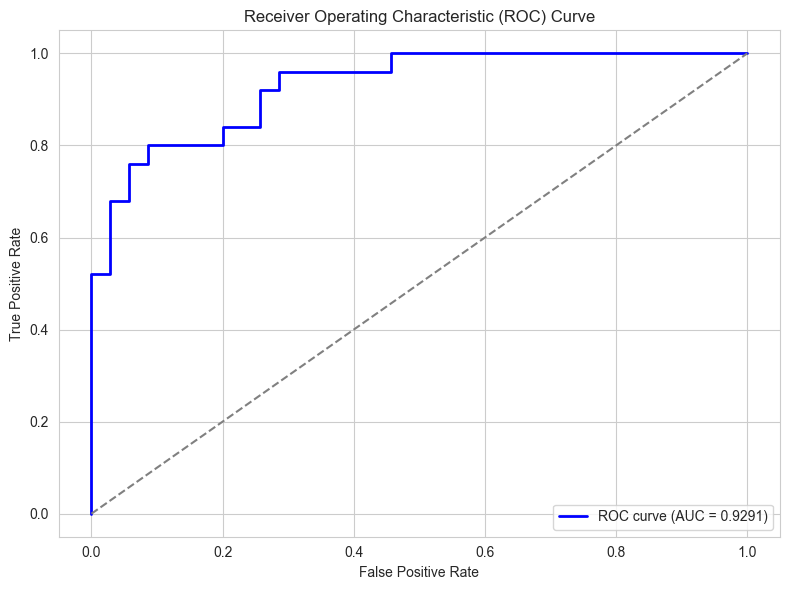

In [17]:
# print_metrics(best_log_reg, X_test, y_test)
print_metrics(best_log_reg, X_test_shuffle, y_test_shuffle)

## Support Vector Machine

### Grid search to find the best parameters

In [18]:
# svc = SVC(probability=True)

# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']      # for rbf
# }

# grid_search = GridSearchCV(
#     estimator=svc,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     verbose=1
# )

# grid_search.fit(X_train_shuffle, y_train_shuffle)

# best_svm = grid_search.best_estimator_
# best_models.append(best_svm)
# print("Best Parameters:", grid_search.best_params_)

### Best parameters are: C=1, gamma='auto', kernel='rbf'

In [19]:
best_svm = SVC(C=1, kernel='rbf', gamma='scale', probability=True)
best_svm.fit(X_train_shuffle, y_train_shuffle)
best_models.append(best_svm)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

In [20]:
# print_classification_report_from_model(best_svm, X_train, y_train)
print_classification_report_from_model(best_svm, X_train_shuffle, y_train_shuffle)

Classification Report (Train data):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       125
           1       0.92      0.88      0.89       112

    accuracy                           0.90       237
   macro avg       0.90      0.90      0.90       237
weighted avg       0.90      0.90      0.90       237



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        35
           1       0.80      0.80      0.80        25

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60




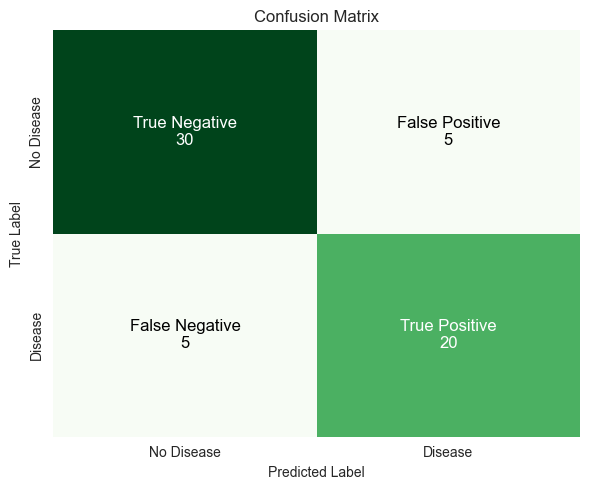

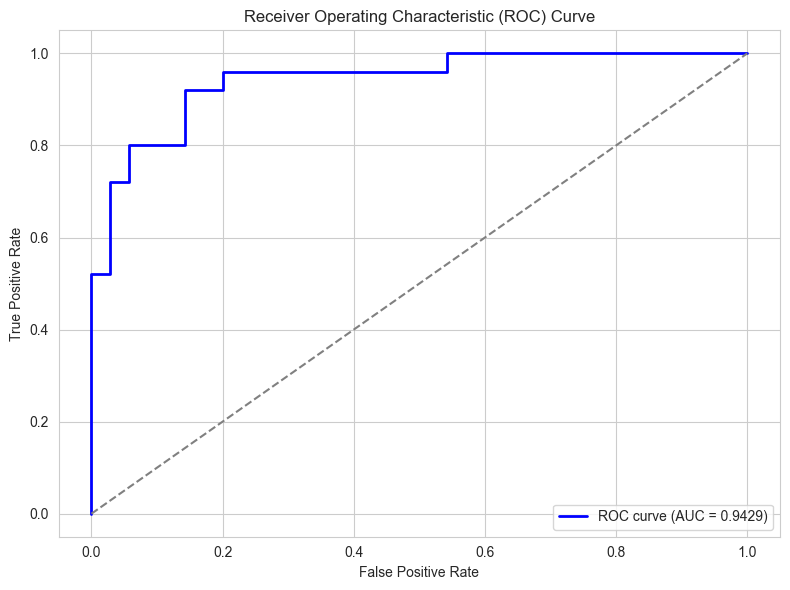

In [21]:
# print_metrics(best_svm, X_test, y_test)
print_metrics(best_svm, X_test_shuffle, y_test_shuffle)

## Random Forest

### Grid search to find the best parameters

In [22]:
# rf = RandomForestClassifier(random_state=42)

# param_grid = {
#     "n_estimators": [50, 100, 200],
#     "max_depth": [3, 5, 7, None],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2", None], 
#     "bootstrap": [True, False]
# }

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=cv,
#     scoring="accuracy",
#     verbose=1
# )
# # grid_search.fit(X_train, y_train)
# grid_search.fit(X_train_shuffle, y_train_shuffle)

# best_rf = grid_search.best_estimator_
# best_models.append(best_rf)
# print("Best Parameters:", grid_search.best_params_)

### Best parameters are: bootstrap=True, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=200

In [23]:
best_rf = RandomForestClassifier(bootstrap=True, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=200)
best_rf.fit(X_train_shuffle, y_train_shuffle)
best_models.append(best_rf)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

In [24]:
# print_classification_report_from_model(best_rf, X_train, y_train)
print_classification_report_from_model(best_rf, X_train_shuffle, y_train_shuffle)

Classification Report (Train data):
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       125
           1       0.93      0.88      0.90       112

    accuracy                           0.91       237
   macro avg       0.91      0.91      0.91       237
weighted avg       0.91      0.91      0.91       237



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        35
           1       0.79      0.76      0.78        25

    accuracy                           0.82        60
   macro avg       0.81      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60




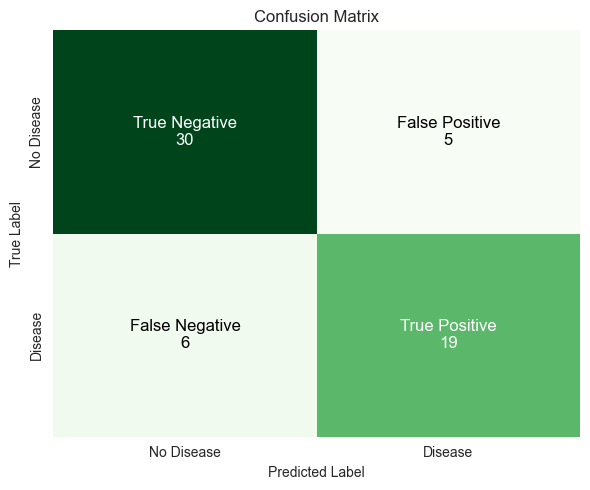

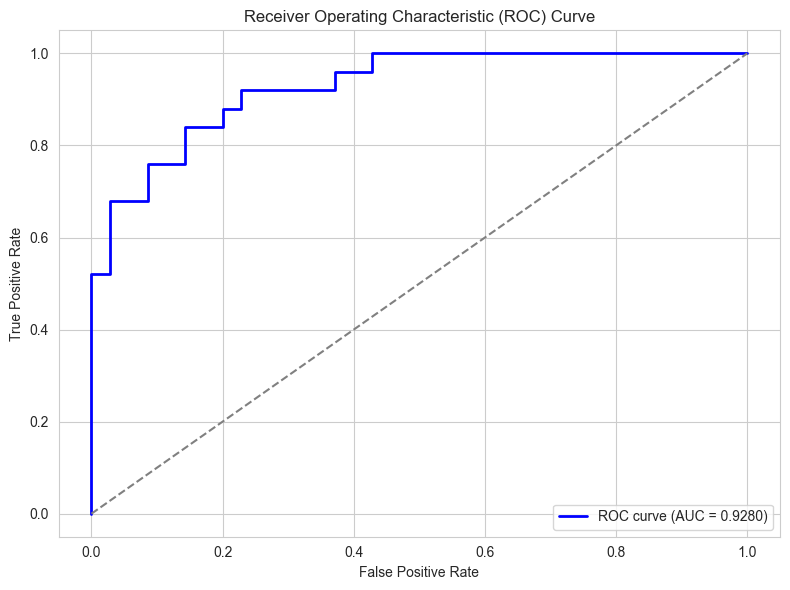

In [25]:
# print_metrics(best_rf, X_test, y_test)
print_metrics(best_rf, X_test_shuffle, y_test_shuffle)

## KNN

### Grid search to find the best parameters

In [26]:
# knn = KNeighborsClassifier()

# param_grid = {
#     'n_neighbors': [5, 7, 9, 15, 30],
#     'weights': ['uniform', 'distance'],
#     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
#     "p": [1, 2],
#     'metric': ['euclidean', 'manhattan']
# }

# grid_search = GridSearchCV(
#     estimator=knn,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     verbose=1
# )

# # grid_search.fit(X_train, y_train)
# grid_search.fit(X_train_shuffle, y_train_shuffle)

# best_knn = grid_search.best_estimator_
# best_models.append(best_knn)
# print("Best Parameters:", grid_search.best_params_)

### Best parameters are: n_neighbors=5, weights='uniform', metric='manhattan', p=1

In [27]:
best_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan', p=1)
best_knn.fit(X_train_shuffle, y_train_shuffle)
best_models.append(best_knn)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

In [28]:
# print_classification_report_from_model(best_knn, X_train, y_train)
print_classification_report_from_model(best_knn, X_train_shuffle, y_train_shuffle)

Classification Report (Train data):
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       125
           1       0.86      0.81      0.83       112

    accuracy                           0.85       237
   macro avg       0.85      0.85      0.85       237
weighted avg       0.85      0.85      0.85       237



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        35
           1       0.82      0.92      0.87        25

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60




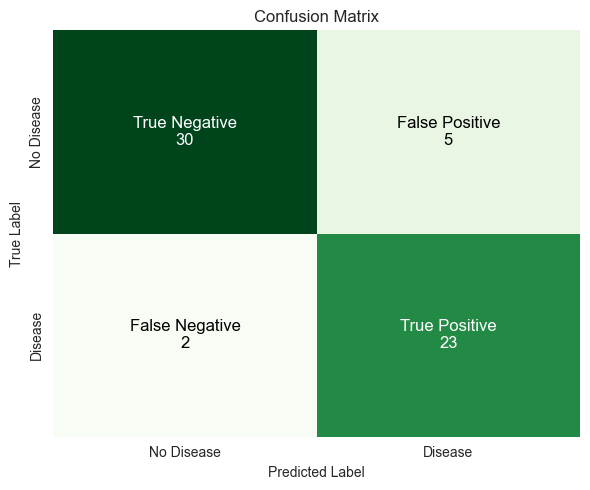

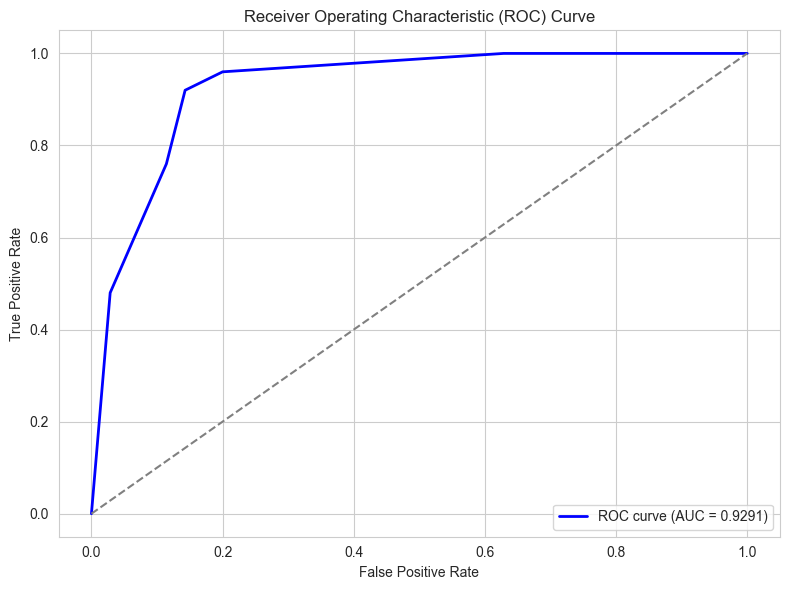

In [29]:
# print_metrics(best_knn, X_test_shuffle, y_test_shuffle)
print_metrics(best_knn, X_test_shuffle, y_test_shuffle)

## XGBoost

### Grid search to find the best parameters

In [30]:
# xboost = xgb.XGBClassifier()

# param_grid = {
#     "learning_rate":[0.01, 0.1, 0.2],
#     "max_depth":[3, 5, 7],
#     "n_estimators":[50, 100, 200],
#     "subsample":[0.7, 0.8, 1.0],
#     "colsample_bytree":[0.7, 0.8, 1.0],
#     # Regularization parameters
#     "reg_alpha": [0, 0.1, 0.5],       # L1 regularization
#     "reg_lambda": [1, 5, 10],         # L2 regularization
#     "gamma": [0, 0.1, 0.5]            # Minimum loss reduction for split
# }

# # param_grid = {
# #     "learning_rate": [0.01, 0.1],
# #     "max_depth": [3, 5],
# #     "n_estimators": [50, 100],
# #     "subsample": [0.8, 1.0],
# #     "colsample_bytree": [0.8, 1.0],
# #     # Regularization parameters
# #     "reg_alpha": [0, 0.1],
# #     "reg_lambda": [1, 5],
# #     "gamma": [0, 0.1]
# # }

# grid_search = GridSearchCV(
#     estimator=xboost,
#     param_grid=param_grid,
#     cv=cv,
#     scoring="accuracy",
#     verbose=1
# )

# # grid_search.fit(X_train, y_train)
# grid_search.fit(X_train_shuffle, y_train_shuffle)

# best_xgb = grid_search.best_estimator_
# best_models.append(best_xgb)
# print("Best Parameters:", grid_search.best_params_)

### Best parameters are: learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, gamma=0.1

In [31]:
best_xgb = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, gamma=0.1)
best_xgb.fit(X_train_shuffle, y_train_shuffle)
best_models.append(best_xgb)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

In [32]:
# print_classification_report_from_model(best_xgb, X_train, y_train)
print_classification_report_from_model(best_xgb, X_train_shuffle, y_train_shuffle)

Classification Report (Train data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00       112

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.74      0.80      0.77        25

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60




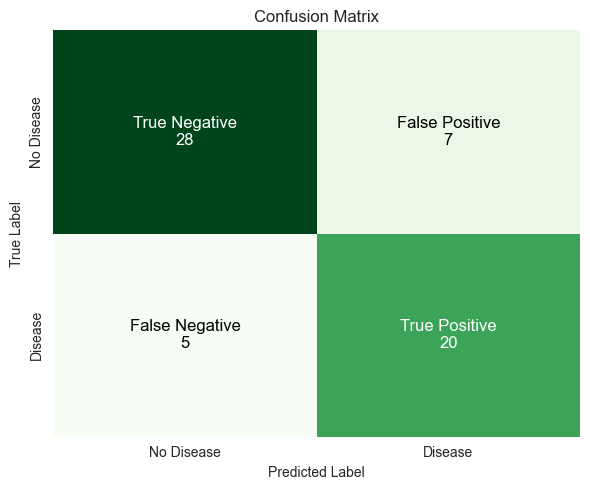

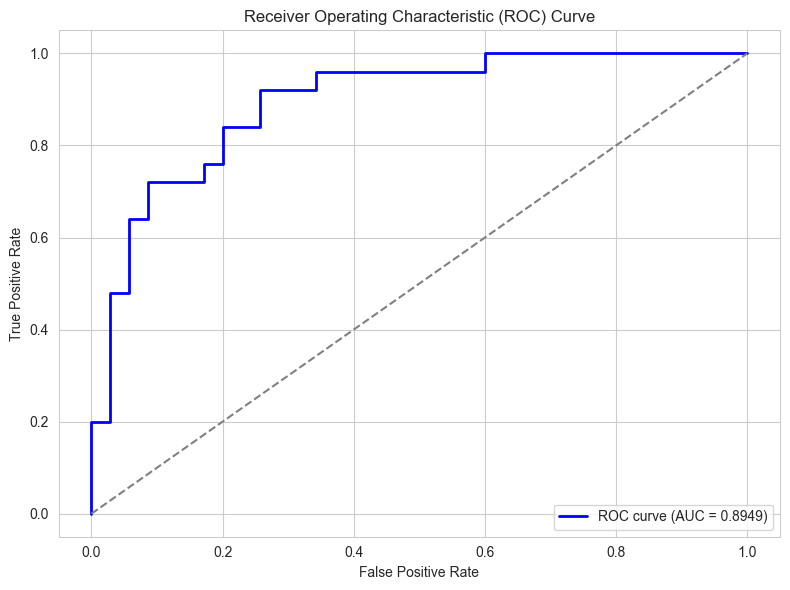

In [33]:
# print_metrics(best_xgb, X_test, y_test)
print_metrics(best_xgb, X_test_shuffle, y_test_shuffle)

## Neural Network

### Architecture

In [34]:
def build_model(lr=0.001, l2_lambda=0.01, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(12, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(8, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(4, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    return model

### Randomized search to find the best(ish) parameters

In [35]:
lr_values = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32, 64]
epochs_list = [50, 100, 150, 200]
l2_lambda_values = [0.001, 0.01, 0.1]
dropout_rates = [0.3, 0.5]

all_combinations = list(product(lr_values, batch_sizes, epochs_list, l2_lambda_values, dropout_rates))

# Randomized search
n_combinations_to_try = 50
random_combos = sample(all_combinations, n_combinations_to_try)

X_train_shuffle = np.array(X_train_shuffle)
y_train_shuffle = np.array(y_train_shuffle)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_params = {}


for lr, batch_size, epochs, l2_lambda, dropout_rate in tqdm(random_combos):
    fold_accuracies = []
    
    for train_index, val_index in skf.split(X_train_shuffle, y_train_shuffle):
        X_train_fold, X_val_fold = X_train_shuffle[train_index], X_train_shuffle[val_index]
        y_train_fold, y_val_fold = y_train_shuffle[train_index], y_train_shuffle[val_index]
        
        model = build_model(lr=lr, l2_lambda=l2_lambda, dropout_rate=dropout_rate)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, verbose=0, 
                  validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
        
        y_pred_fold = (model.predict(X_val_fold, verbose=0) > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        fold_accuracies.append(accuracy)
    
    mean_accuracy = np.mean(fold_accuracies)
    
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs, 'l2_lambda': l2_lambda, 'dropout_rate': dropout_rate}

print("Best Parameters:", best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [1:16:24<00:00, 91.70s/it] 


Best Parameters: {'lr': 0.01, 'batch_size': 32, 'epochs': 200, 'l2_lambda': 0.01, 'dropout_rate': 0.3}


### Grid search to find the best parameters

In [36]:
# lr_values = [0.0001, 0.001, 0.01, 0.1]
# batch_sizes = [8, 16, 32, 64]
# epochs_list = [50, 100, 150, 200]
# reg_l2_values = [0.001, 0.01, 0.1]
# dropout_rates = [0.3, 0.5, 0.7] 

# # Prepare the KFold cross-validation
# # X_train = np.array(X_train)
# # y_train = np.array(y_train)

# X_train = np.array(X_train_shuffle)
# y_train = np.array(y_train_shuffle)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# best_accuracy = 0
# best_params = {}

# for lr, batch_size, epochs, l2_lambda, dropout_rate in tqdm(list(product(lr_values, batch_sizes, epochs_list, reg_l2_values, dropout_rates))):
#     fold_accuracies = []
    
#     for train_index, val_index in skf.split(X_train, y_train):
#         X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#         y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
#         model = build_model(lr=lr, l2_lambda=l2_lambda, dropout_rate=dropout_rate)
        
#         early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
#         model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, verbose=0, 
#                   validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
        
#         y_pred_fold = (model.predict(X_val_fold, verbose=0) > 0.5).astype(int)
        
#         accuracy = accuracy_score(y_val_fold, y_pred_fold)
#         fold_accuracies.append(accuracy)
    
#     mean_accuracy = np.mean(fold_accuracies)
    
#     if mean_accuracy > best_accuracy:
#         best_accuracy = mean_accuracy
#         best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs, 'l2_lambda': l2_lambda, 'dropout_rate': dropout_rate}

# print("Best Parameters:", best_params)

### Best(ish) parameters are: lr=0.001, l2_lambda=0.01, batch_size=8, epochs=200

In [37]:
# best_nn = build_model(lr=0.001, l2_lambda=0.01)
# best_nn.fit(X_test_shuffle, y_test_shuffle, batch_size=8, epochs=200, verbose=0)
# best_models.append(best_nn)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Classification Report (Train data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       128
           1       0.97      0.95      0.96       109

    accuracy                           0.97       237
   macro avg       0.97      0.97      0.97       237
weighted avg       0.97      0.97      0.97       237

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.96      0.96      0.96        25

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60




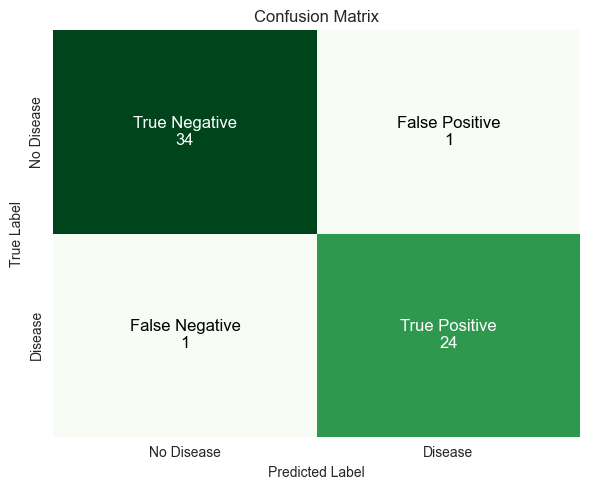

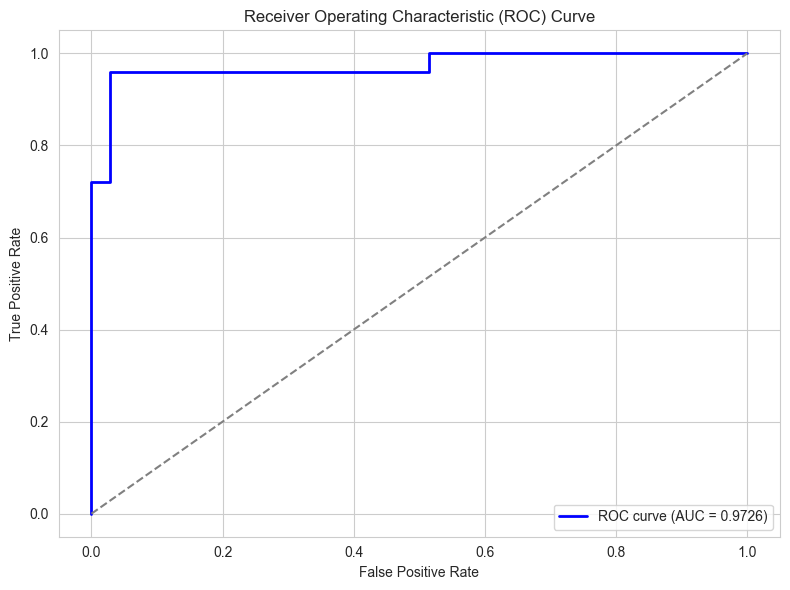

In [38]:
best_nn = build_model(lr=best_params['lr'], l2_lambda=best_params['l2_lambda'])
best_nn.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)
best_models.append(best_nn)

print_classification_report_from_model(best_nn, X_train, y_train)

# print_metrics(best_nn, X_test, y_test)
print_metrics(best_nn, X_test_shuffle, y_test_shuffle)

In [39]:
best_nn.summary()

Model: "sequential_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1000 (Dense)              │ (None, 12)             │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_750 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1001 (Dense)              │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_751 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_752 (Dropout)           │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1003 (Dense)              │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 373 (1.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 748 (2.93 KB)

## Comparison of all models

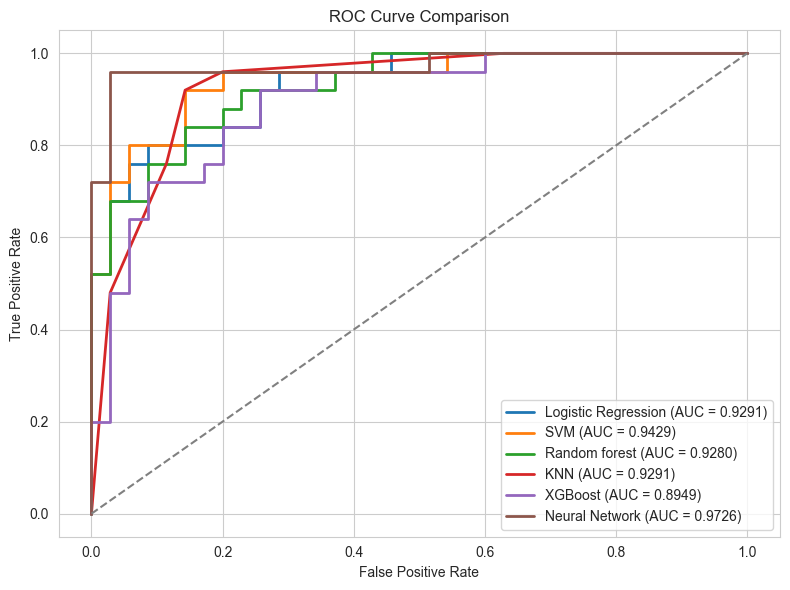

In [40]:
plot_roc_curves(best_models, model_names, X_test_shuffle, y_test_shuffle)